In [20]:
from collections import defaultdict
import math
import time
import copy
import itertools
import warnings
from datetime import datetime
import os
warnings.filterwarnings('ignore')

import numpy as np

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('../runs/ae_{}'.format(datetime.now()))

ImageFile.LOAD_TRUNCATED_IMAGES=True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
number_epochs = 10
batch_size = 128
learning_rate = 1e-4

# Load data

In [4]:
transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('../dataset/', transform=transform_image, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
print(f"Number of training images: {len(dataset)}")
print(f"Size of each image: {dataset[0][0].size()}")

Number of training images: 60000
Size of each image: torch.Size([1, 28, 28])


## show some images

In [6]:
def imshow(tensor, ax=None):
    np_img = tensor.permute(1, 2, 0)
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(np_img)
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


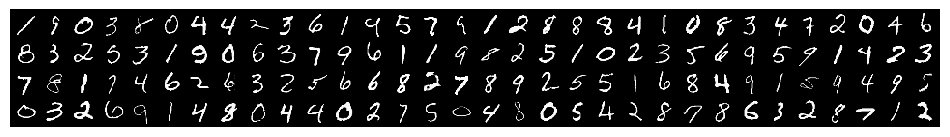

In [7]:
# get some random training images
data_iter = iter(data_loader)
sample_images, labels = data_iter.next()
# show images
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
grid = torchvision.utils.make_grid(sample_images, nrow=int(batch_size/4))
# write to tensorboard
writer.add_image('mnist', grid)
imshow(grid, ax=ax)

# Create MLP AutoEncoder model

In [8]:
class AutoEncoder(nn.Module):
    
    def __init__(self, input_size=28, hidden_size=3):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size * input_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, hidden_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, input_size * input_size), 
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x    

In [9]:
ae = AutoEncoder()
ae

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [10]:
# inspect model in tensorboard
writer.add_graph(ae, torch.rand(1, 1, 28 * 28))

In [11]:
def to_image(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


def imshow_tensor(inputs):
    grid = torchvision.utils.make_grid(inputs, normalize=True, scale_each=True, nrow=int(batch_size/4))
    fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
    imshow(grid, ax=ax)
    plt.show()
    return fig

In [12]:
def train(model, optimizer, criterion, data_loader, epochs, flatten=True, model_name='mlp'):
    model = model.to(device)
    # define training variables
    since = time.time()
    best_weights = copy.deepcopy(model.state_dict())

    for epoch in range(1, epochs+1):        
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            if flatten:
                inputs = inputs.view(inputs.size(0), -1)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # statistics
            running_loss += loss.item() * inputs.size(0)

        batch_size = len(data_loader.dataset)
        epoch_loss = running_loss / batch_size

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, epochs, epoch_loss))
        print('-' * 60)
        # ...log the running loss to tensorboard
        writer.add_scalar('loss/{}'.format(model_name), epoch_loss, epoch)
        
        imgs = to_image(outputs.cpu().data)
        fig = imshow_tensor(imgs)
        writer.add_figure('Generated-Image/{}'.format(model_name), fig, epoch)
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

Epoch [1/10], Loss: 0.3895
------------------------------------------------------------


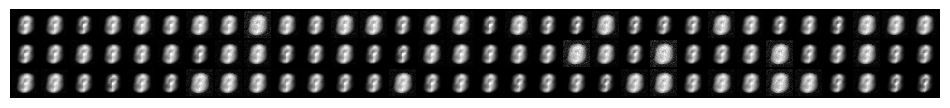

Epoch [2/10], Loss: 0.2449
------------------------------------------------------------


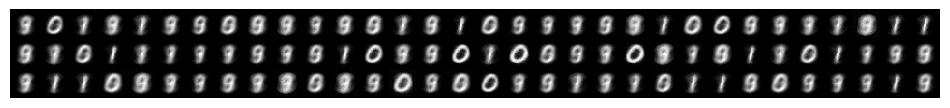

Epoch [3/10], Loss: 0.2272
------------------------------------------------------------


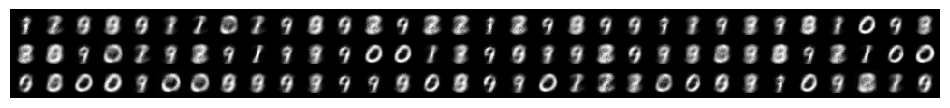

Epoch [4/10], Loss: 0.2098
------------------------------------------------------------


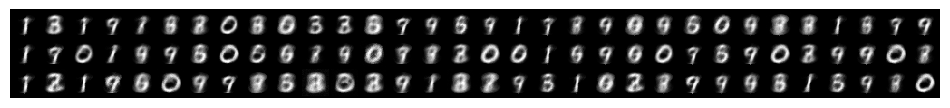

Epoch [5/10], Loss: 0.1981
------------------------------------------------------------


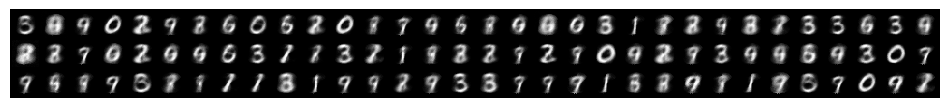

Epoch [6/10], Loss: 0.1922
------------------------------------------------------------


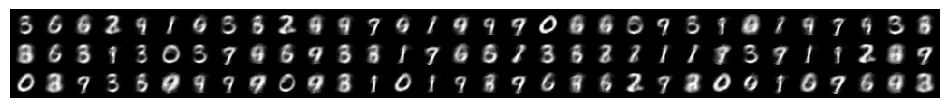

Epoch [7/10], Loss: 0.1877
------------------------------------------------------------


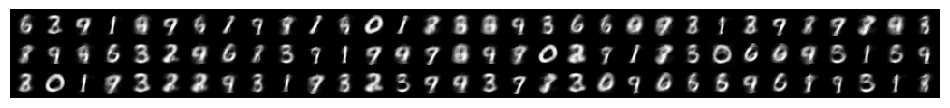

Epoch [8/10], Loss: 0.1840
------------------------------------------------------------


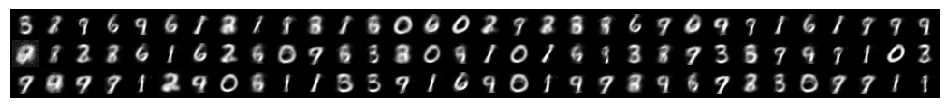

Epoch [9/10], Loss: 0.1810
------------------------------------------------------------


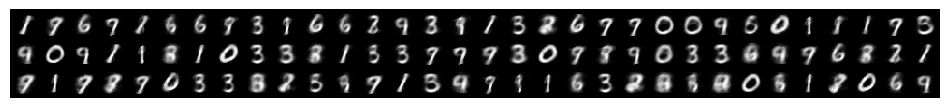

Epoch [10/10], Loss: 0.1785
------------------------------------------------------------


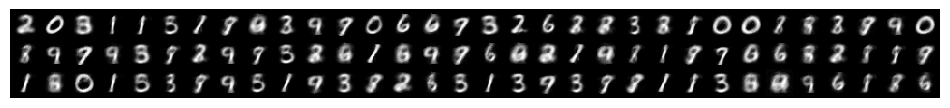

Training complete in 1m 49s


In [13]:
ae = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate, weight_decay=1e-5)
m = train(ae, optimizer, criterion, data_loader, 10, model_name='mlp')

# Conv AutoEncoder model

In [14]:
class ConvAutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,(3,3),stride=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16,8,(3,3), stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8,16,(3,3), stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16,8,(5,5), stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x    

In [15]:
conv_ae = ConvAutoEncoder()
conv_ae

ConvAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [16]:
# inspect model in tensorboard
writer.add_graph(conv_ae, torch.rand(1, 1, 28, 28))

Epoch [1/10], Loss: 0.7407
------------------------------------------------------------


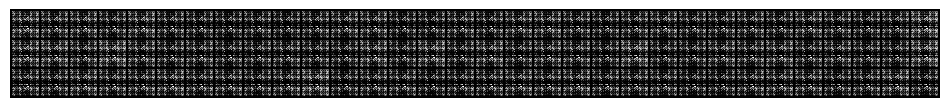

Epoch [2/10], Loss: 0.3935
------------------------------------------------------------


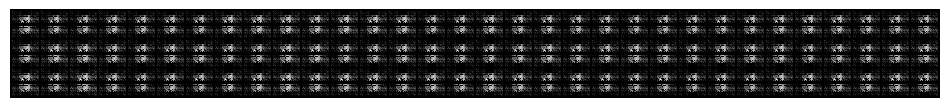

Epoch [3/10], Loss: 0.3409
------------------------------------------------------------


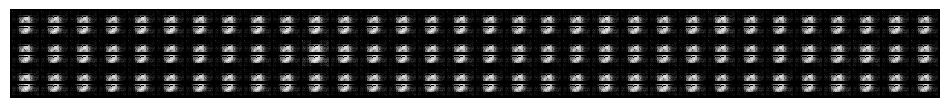

Epoch [4/10], Loss: 0.3257
------------------------------------------------------------


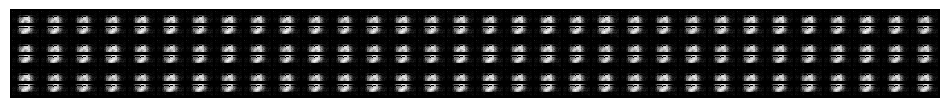

Epoch [5/10], Loss: 0.3192
------------------------------------------------------------


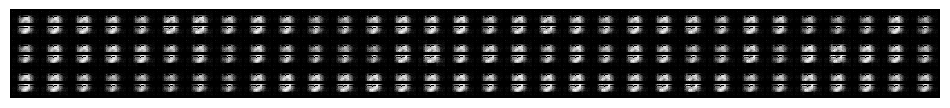

Epoch [6/10], Loss: 0.3107
------------------------------------------------------------


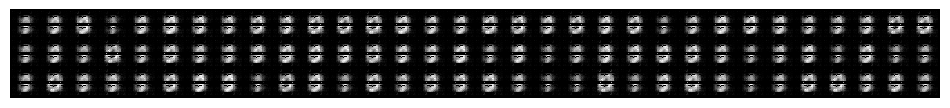

Epoch [7/10], Loss: 0.3023
------------------------------------------------------------


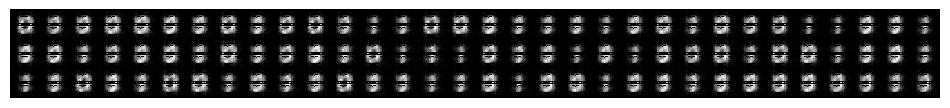

Epoch [8/10], Loss: 0.2962
------------------------------------------------------------


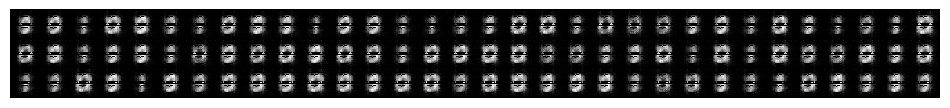

Epoch [9/10], Loss: 0.2855
------------------------------------------------------------


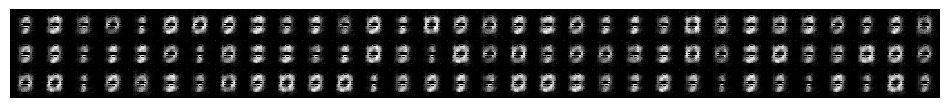

Epoch [10/10], Loss: 0.2712
------------------------------------------------------------


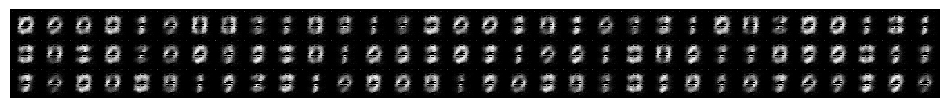

Training complete in 2m 31s


In [17]:
conv_ae = ConvAutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(conv_ae.parameters(), lr=learning_rate, weight_decay=1e-5)
conv = train(conv_ae, optimizer, criterion, data_loader, 10, flatten=False, model_name='cnn')

# Denoising Autoencoders